# Setup


In [ ]:
import warnings
warnings.filterwarnings('ignore')


import os
os.environ["DGLBACKEND"] = "pytorch"

import pandas as pd
import numpy as np

##--Modelling--##
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import NeighborSampler, DataLoader



FileNotFoundError: [WinError 2] The system cannot find the file specified: '../AML-GNN-project'

# 0️⃣ Utilities Functions

In [2]:
def label_encoder(df:pd.DataFrame, column_1:str, column_2:str, label_col_name:str):
    '''Generate the labels for the specify column for the dataframe'''
    a = set(df[column_1].unique())
    b = set(df[column_2].unique())
    label_table = a.union(b)
    label_table = pd.DataFrame(label_table,columns=[label_col_name])
    label_encoder = LabelEncoder()
    label_table['label'] = label_encoder.fit_transform(label_table[label_col_name])
    _mapping = dict(zip(label_table[label_col_name], label_table['label']))
    df[column_1] = df[column_1].map(_mapping)
    df[column_2] = df[column_2].map(_mapping)
    return df, label_table

def get_node_label(df:pd.DataFrame):
    '''Return label 1 if both the payer and receiver account are involved in a laundering transaction'''
    laundering_records = df[df['is_laundering']==1]
    from_accounts = set(laundering_records['from_account'])
    to_accounts = set(laundering_records['to_account'])
    laundering_accounts = pd.DataFrame()
    laundering_accounts['account'] = list(from_accounts | to_accounts) 
    laundering_accounts['is_laundering'] = 1
    return laundering_accounts
    


# 1️⃣ Graph Construction

The graph will use all unique account numbers (Both the paying end and receving end) as node, with the transaction between the account as the edges of the graph.

The following pre-processing steps has been prior the construction of the graph:
1. Create account IDs for each account by prefix each account number with the bank code
2. Create labels fro account (now encode with bank code), currency and payment format

In [3]:
trans_df = pd.read_parquet("../00_data/trans_df.parquet")
DTYPE = np.float32
print("Raw Sample Data:")
display(trans_df.head(1))
tmp = trans_df['is_laundering'].value_counts()
print(f"Size of the Dataset: {trans_df.shape}")
print(f"Number of non-laundering samples: {tmp[0]}( {round(tmp[0]/tmp.sum()*100, 3)}% ) \nNumber of laundering samples: {tmp[1]} ( {round(tmp[1]/tmp.sum()*100, 3)}% )")


##Create unique ID account prefix with bank
trans_df['from_account'] = trans_df['from_bank'] + "_" + trans_df['from_account']
trans_df['to_account'] = trans_df['to_bank'] + "_" + trans_df['to_account']

##--Label encoding for account number--##
trans_df, account_label_table = label_encoder(trans_df, "from_account", "to_account", 'account')
trans_df, currency_label_table = label_encoder(trans_df, "payment_currency", "receiving_currency", 'currency')

##--Label encoding for payment_format--##
payment_format_label_encoder = LabelEncoder()
trans_df['payment_format'] = payment_format_label_encoder.fit_transform( trans_df['payment_format'] )
print("/nSample  Data after Transformation")

##--PreProcesss Timestamp with min max normalization--##
trans_df['timestamp'] = pd.to_datetime(trans_df['timestamp'])
trans_df['timestamp'] = trans_df['timestamp'].apply(lambda x: x.value)
trans_df['timestamp'] = (trans_df['timestamp']-trans_df['timestamp'].min())/(trans_df['timestamp'].max()-trans_df['timestamp'].min())


display(trans_df.head())


Raw Sample Data:


,transaction_id,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,0,2022-09-01 00:20:00,010,8000EBD30,010,8000EBD30,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0


Size of the Dataset: (5078345, 12)
Number of non-laundering samples: 5073168( 99.898% ) 
Number of laundering samples: 5177 ( 0.102% )
/nSample  Data after Transformation


,transaction_id,timestamp,from_bank,from_account,to_bank,to_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering
0,0,0.000786,010,132152,010,132152,3697.34,12,3697.34,12,5,0
1,1,0.000786,03208,417156,001,39897,0.01,12,0.01,12,3,0
2,2,0.000000,03209,417458,03209,417458,14675.57,12,14675.57,12,5,0
3,3,0.000079,012,192342,012,192342,2806.97,12,2806.97,12,5,0
4,4,0.000236,010,132160,010,132160,36682.97,12,36682.97,12,5,0


## 1.1 Node Features



In [4]:
account_amt_paid_agg_df  = pd.pivot_table(trans_df, 
               index='from_account',
               columns = 'payment_currency',
               aggfunc={
                   'amount_paid':np.mean
               }
               ).reset_index()
account_amt_paid_agg_df.columns = ['account'] + ["_".join(map(str, col)).strip("_") for col in account_amt_paid_agg_df.columns.to_flat_index()[1:]]
account_amt_paid_agg_df.fillna(0, inplace=True)

account_amt_received_agg_df  = pd.pivot_table(trans_df, 
               index='to_account',
               columns = 'receiving_currency',
               aggfunc={
                   'amount_received':np.mean
               }
               ).reset_index()
account_amt_received_agg_df.columns = ['account'] + ["_".join(map(str, col)).strip("_") for col in account_amt_received_agg_df.columns.to_flat_index()[1:]]
account_amt_received_agg_df.fillna(0, inplace=True)

node_features = pd.merge(account_amt_paid_agg_df,account_amt_received_agg_df, on='account', how="outer")
node_features.fillna(0, inplace=True)
node_labels = get_node_label(trans_df)
node_label_df = pd.merge(account_label_table, node_labels.rename({"account":"label"}, axis=1), on='label', how="left")
node_label_df.fillna(0, inplace=True)
node_label_df.sort_values(by='label', inplace=True)

print("\nNode Features Sample:")
display(node_features.head())


print("\nNumber of Laundering Accounts vs Non-Laundering Accounts:")
result = (
    node_label_df.groupby('is_laundering')
      .size()
      .reset_index(name='count')
)
result['percentage'] = (result['count'] / result['count'].sum() * 100).round(2)

print(result)



Node Features Sample:


,account,amount_paid_0,amount_paid_1,amount_paid_3,amount_paid_4,amount_paid_5,amount_paid_6,amount_paid_7,amount_paid_11,amount_paid_12,...,amount_received_6,amount_received_7,amount_received_11,amount_received_12,amount_received_13,amount_received_14,amount_received_2,amount_received_8,amount_received_9,amount_received_10
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000e-02,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.469543e+05,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.590448e+06,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,7.915011e+04,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.038217e+06,0.0,0.0,0.0,0.0,0.0



Number of Laundering Accounts vs Non-Laundering Accounts:
   is_laundering   count  percentage
0            0.0  508731       98.77
1            1.0    6357        1.23


## 1.2 Edge Features

In [5]:
edge_index = torch.stack([torch.from_numpy(trans_df['from_account'].values), torch.from_numpy(trans_df['to_account'].values)], dim=0)
print(edge_index)


edge_features = trans_df[['timestamp','amount_received','receiving_currency','amount_paid','payment_currency','payment_format']]
edge_features.head()

tensor([[132152, 417156, 417458,  ..., 237173, 363030, 237441],
        [132152,  39897, 417458,  ..., 363031, 363031, 363031]])


,timestamp,amount_received,receiving_currency,amount_paid,payment_currency,payment_format
0,0.000786,3697.34,12,3697.34,12,5
1,0.000786,0.01,12,0.01,12,3
2,0.000000,14675.57,12,14675.57,12,5
3,0.000079,2806.97,12,2806.97,12,5
4,0.000236,36682.97,12,36682.97,12,5


## 1.3 Graph Representation

In [32]:
pwd

'c:\\Users\\tanka\\Dropbox\\08-1 NUS Master in Computing AI specialization\\CS5284 Graph Machine Learning\\04Project\\AML-GNN-project\\supervised_graph_src'

In [ ]:
try:
    ##--Load Graphs--##
    print("\nLoading saved graph...")
    (g,), _ = dgl.load_graphs("../00_data/trasaction_graph.dgl")
except:
    ##--Create Graph--##
    print("\nCreating graph...")
    g = dgl.graph(
        (edge_index[0], # From Accounts
        edge_index[1]), # To Accounts
        num_nodes=account_label_table.shape[0]
    )
    ##--Assign Node Features & Label--##
    g.ndata["X"] = torch.from_numpy(node_features.to_numpy(dtype='float32'))
    g.ndata['y'] = torch.from_numpy(
        node_label_df['is_laundering'].to_numpy() ).to(torch.int64)       

    ##--Assign Edge Features--##
    g.edata['a'] = torch.from_numpy(edge_features.to_numpy(dtype='float32'))

    ##--Save Graph--##
    dgl.save_graphs("../00_data/trasaction_graph.dgl", g)

print("Num of nodes: ", g.num_nodes())
print("Num of edges: ",g.num_edges())



Loading saved graph...
Num of nodes:  515088
Num of edges:  5078345


# 2️⃣ Node Classification

## 2.1 Train/Test Split

In [8]:
y_np = g.ndata['y'].cpu().numpy()
idx = np.arange(g.num_nodes())

# --- stratified split (needs sklearn). If you don't want sklearn, use random split instead.
from sklearn.model_selection import train_test_split
idx_tr, idx_te = train_test_split(idx, test_size=0.15, stratify=y_np, random_state=42)
idx_tr, idx_va = train_test_split(idx_tr, test_size=0.1765, stratify=y_np[idx_tr], random_state=42)  # ~15% val

train_mask = torch.zeros(g.num_nodes(), dtype=torch.bool); train_mask[idx_tr] = True
val_mask   = torch.zeros(g.num_nodes(), dtype=torch.bool); val_mask[idx_va] = True
test_mask  = torch.zeros(g.num_nodes(), dtype=torch.bool); test_mask[idx_te] = True

g.ndata['train_mask'] = train_mask
g.ndata['val_mask']   = val_mask
g.ndata['test_mask']  = test_mask


In [18]:
labels = g.ndata['y']
count_train_laundering = (labels[train_mask] == 1).sum().item()
count_val_laundering = (labels[val_mask] == 1).sum().item()
count_test_laundering = (labels[test_mask] == 1).sum().item()
print("Number of Train nodes with laundering account :", count_train_laundering)
print("Number of Validate nodes with laundering account :", count_val_laundering)
print("Number of Test nodes with laundering account :", count_test_laundering)
print("Total Laundering nodes :", count_train_laundering + count_val_laundering + count_test_laundering)

Number of Train nodes with laundering account : 4449
Number of Validate nodes with laundering account : 954
Number of Test nodes with laundering account : 954
Total Laundering nodes : 6357


In [19]:
sampler = NeighborSampler([15, 10])  # 2-layer sampling

train_nids = torch.nonzero(g.ndata['train_mask']).squeeze(1)
val_nids   = torch.nonzero(g.ndata['val_mask']).squeeze(1)
test_nids  = torch.nonzero(g.ndata['test_mask']).squeeze(1)

train_loader = DataLoader(
    g, train_nids, sampler,
    batch_size=2048, shuffle=True, drop_last=False, num_workers=0
)
val_loader = DataLoader(
    g, val_nids, sampler,
    batch_size=4096, shuffle=False, drop_last=False, num_workers=0
)
test_loader = DataLoader(
    g, test_nids, sampler,
    batch_size=4096, shuffle=False, drop_last=False, num_workers=0
)

## 2.2 Modelling

In [20]:
import torch.nn as nn
import torch.nn.functional as F
import dgl.nn as dglnn

class SAGE(nn.Module):
    def __init__(self, in_feats, hidden, num_classes, dropout=0.2):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(in_feats, hidden, 'mean')
        self.conv2 = dglnn.SAGEConv(hidden, num_classes, 'mean')
        self.dropout = nn.Dropout(dropout)

    def forward(self, blocks, x):
        h = self.conv1(blocks[0], x)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(blocks[1], h)
        return h  # logits for output nodes of the last block


In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_feats = g.ndata['X'].shape[1]
num_classes = int(g.ndata['y'].max().item() + 1)

model = SAGE(in_feats, hidden=64, num_classes=num_classes).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)


y = g.ndata['y']
counts = torch.bincount(y, minlength=2).float()
weights = (counts.sum() / counts.clamp(min=1))
weights = (weights / weights.sum())

# weights = torch.tensor([0.2, 0.8])  # Define own weights to handle classs imbalance
loss_fn = nn.CrossEntropyLoss(weight=weights)


def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    all_preds = []
    all_labels = []

    for input_nodes, output_nodes, blocks in loader:
        blocks = [b.to(device) for b in blocks]
        x = blocks[0].srcdata['X'].to(device)
        y = g.ndata['y'][output_nodes].to(device)

        logits = model(blocks, x)
        loss = loss_fn(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        ##--Compute Metrics--##
        total_loss += loss.item() * y.shape[0]
        pred = logits.argmax(1)
        total_correct += (pred == y).sum().item()
        total_count += y.shape[0]

        ##--Store metrics for confusion matrix--##
        all_preds.append(pred.detach().cpu())
        all_labels.append(y.detach().cpu())
    
    # Combine all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    # Compute confusion matrix (CPU numpy arrays)
    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    avg_loss = total_loss / max(1, total_count)
    accuracy = total_correct / max(1, total_count)

    return avg_loss, accuracy, cm

for epoch in range(1, 51):
    tr_loss, tr_acc, _ = run_epoch(train_loader, True)
    va_loss, va_acc, _ = run_epoch(val_loader, False)
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

test_loss, test_acc, cm = run_epoch(test_loader, train=False)
print(f"Test loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")
print("Confusion matrix:\n", cm)


Epoch 01 | train 4606110.4940/0.5306 | val 6023663.0637/0.6337
Epoch 02 | train 2704207.3706/0.5845 | val 5709965.7256/0.6215
Epoch 03 | train 4245380.3649/0.5970 | val 4999987.8539/0.6074
Epoch 04 | train 2120602.4724/0.6133 | val 3660937.8575/0.6180
Epoch 05 | train 4457650.8542/0.5992 | val 2598782.1357/0.5272
Epoch 06 | train 3157300.3126/0.6005 | val 3928206.4073/0.6201
Epoch 07 | train 2161708.2581/0.6186 | val 4975502.3535/0.6387
Epoch 08 | train 2612370.6808/0.5493 | val 3620846.8172/0.4842
Epoch 09 | train 1738479.0919/0.6028 | val 5269040.4012/0.6661
Epoch 10 | train 1838975.6306/0.6673 | val 5362399.4319/0.6719
Epoch 11 | train 2807660.6863/0.6934 | val 4458165.2482/0.6797
Epoch 12 | train 1688173.1579/0.6790 | val 4693167.4607/0.6773
Epoch 13 | train 1594340.0459/0.6882 | val 3561682.9172/0.6531
Epoch 14 | train 1827359.8922/0.7189 | val 4282377.0354/0.7395
Epoch 15 | train 1567814.1274/0.7217 | val 3624455.7716/0.6665
Epoch 16 | train 3707308.3667/0.7157 | val 2990469.8752

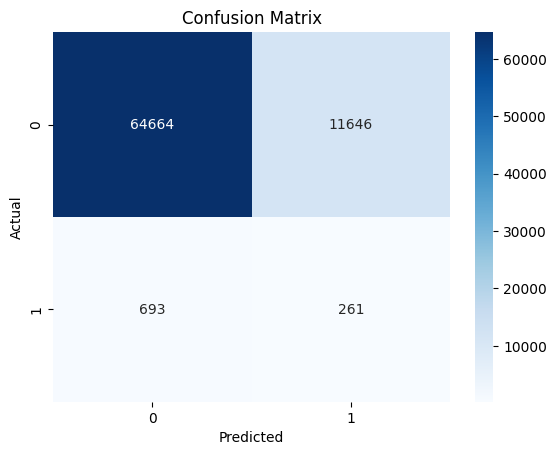

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [31]:
TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.0219
Recall:    0.2736
F1-score:  0.0406
